# Clustering & Geodemographics

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

## Clustering in Python

The most commonly-used _aspatial_ clustering algorighms are all found in [scikit-learn](http://scikit-learn.org/stable/), so that will be the focus of this practical. But just as there are aspatial and spatial statistics, there are also _spatially-aware_ clustering algorithms to be found in [PySAL](http://pysal.readthedocs.io/en/latest/), the Python Spatial Analysis Library.

### Clustering in sklearn

One organisation recently produced a handy scikit-learn cheatsheet that you should [download](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf). The terminology used in scikit-learn is rather different from anything you will have encountered before (unless you've studied computer science and, possibly, statistics) so it's worth spending a few minutes mapping what you already know on to the sklearn framework:

  | Continuous | Categorical
- | ---------- | -----------
**Supervised** | Regression | Classification
**Unsupervised** | Dimensionality Reduction | Clustering

So clustering is a form of unsupervised (because we don't train the model on what a 'good' result looks like) and categorical (because we get labels out of the model, not predictors) machine learning. Here's a map to sklearn's algorithms and how to navigate them:

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/"><img alt="SciKit-Learn Algorithm Map" src="http://scikit-learn.org/stable/_static/ml_map.png"></a>

### Clustering in PySAL

PySAL is similarly complex and _also_ has a map to help you navigate its complexities -- in this case we're particularly interested in the orange 'branch' of PySAL (labelled clustering!):

![PySAL Map](http://darribas.org/gds_scipy16/content/figs/pysal.png)

### Which Approach is Right?

The reason that there is no 'right' approach (as I said above) is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" /></a>

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy. So my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook a bigger cluster because it's 'hidden' inside an area with lots of non-sufferers. In that case, I want my clusters to take geography into account because I'm looking for agglomerations. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

## Obtaining Geodemographic Data

For the sake of simplicity -- and to help you build on what you learned last year -- we're going to work with the NS-SeC data for London to try to produce a classification of LSOAs based on the mix of socio-economic groups in each area. You will also find [Geocomputation: A Practical Primer](https://uk.sagepub.com/en-gb/eur/geocomputation/book241023) to be rather useful here: although the implementation is in the R programming language, the concerns and the approach are exactly the same.

### InFuse

In case you've forgotten, nearly the _entire_ Census is available to download from [InFuse](http://infuse2011.ukdataservice.ac.uk/). You will need to download the "NS-SeC (National Statistics Socio-economic Classification)" data set cut by **Age** so that it only includes people between 16 and 74.

#### Demographic Data

The criteria we want are:
* The 2011 Census.
* NS-SeC NS-SeC (National Statistics Socio-economic Classification).
* Select the first data set listed (should be just Age and NS-SeC).
* Tick _only_ the 16-74 age group option.
* Tick the following NS-SeC classifications: Total, 1 (+ 1.1, 1.2); 2 (+ L4, L5, L6); 3; 4 (+ L8, L9); 5 (+ L10, L11); 6; 7; 8; NC (+ L15, L16). 
* Click 'Add' to add these to your selection

You should have 21 category combinations when this is done.

**_Note:_** the 'L' levels are hidden by the '+' buttons -- so to get at 1.1 and 1.2 you need to click on the '+' next to Group 1, and so on.

#### Geographic Areas

We want London LSOAs, which means that you need to:
* Expand the Regions section (click on the '+')
* Expand hte London section (click on the next '+')
* Tick LSOAs (4835 areas)
* Click 'Add' to add these to your selection

### ONS Boundary Data

Now we need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

**_Note:_** be sure that you select the **2011** data, not the **2001** data.

### Setup

You should drag both the LSOA boundary file and the NS-SeC zipfile into a 'data' directory that is the same directory as this notebook so that they're easy to access. You should then:
* Unzip _only_ the LSOA zipfile.
* Rename the directory containing LSOA data to 'lsoa'.
* Rename the Census zipfile to 'AGE_NSSEC_UNIT.zip'

And we're ready to go!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking (I haven't used it) [wrapper to the Census API](https://pypi.python.org/pypi/census).

## Getting to Work

To get started we're going to work with pandas and geopandas -- again, nothing new so far but you'll see we've got some new libraries here.

### Specifying the Kernel

**_Note:_** Before you go any further, we need to check that you've got the right 'Kernel' (virutal environment) specified in Jupyter. At top right it should say "Python [spats]" and that is the environment that we want to work in: spats is short Spatial Analysis and that contains all of the libraries that we need for our research. There are other kernels configured and these can be accessed by clicking on the 'Kernel' menu item and then 'Change Kernel'. This feature is well beyond the scope of this practical, but it basically allows you to run multiple 'versions' of Python with different libraries or versions of libraries installed at the same time.

### Importing the Libraries

In [1]:
import pysal as ps
import pandas as pd
import geopandas as gpd
import seaborn as sns
import clusterpy as cpy
import os
import re
import numpy as np
import zipfile

import random
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

/Applications/anaconda/envs/spats/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ClusterPy: Library of spatially constrained clustering algorithms


### Loading the Geodata

Unlike the NS-SeC data this is fairly straightforward using geopandas:

In [4]:
gdf = gpd.read_file(os.path.join('data','lsoa','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp'))
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.head(2)

Shape of LSOA file: 34753 rows by 7 columns


geometry   lsoa11cd  \
0  POLYGON ((532106.8939689073 182011.4758723566,...  E01000001   
1  POLYGON ((532748.6236845022 181787.1247154782,...  E01000002   

              lsoa11nm            lsoa11nmw  objectid  st_areasha  st_lengths  
0  City of London 001A  City of London 001A         1     133,321       2,292  
1  City of London 001B  City of London 001B         2     226,191       2,434

### Loading the Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!

In [5]:
z = zipfile.ZipFile(os.path.join('data','AGE_NSSEC_UNIT.zip'))

df = pd.read_csv(z.open('Data_AGE_NSSEC_UNIT.csv'), skiprows=[0])
print("Shape of dataframe is {0} rows by {1} columns".format(df.shape[0], df.shape[1]))
df.head(2)

IOError: [Errno 2] No such file or directory: 'data/AGE_NSSEC_UNIT.zip'

#### Tidying Up

OK, that's not the most 'useful' of column headings: quite a lot of typing and redundancy to say the least! But we can use code to clean this up!

Let's step through it:
* We first test for the existence of a column at the far end of the file -- since `pandas` stores its columns as an index, we need to extract the values from the index (which returns a `numpy` array) and then look through it for something match `Unnamed: 26`.
* Next, we create a new list called `colnames` and we initialise it with the names we want to use for columns `Unnamed: 0` through `Unnamed: 4`.
* Then we're going to iterate over the remaining column names to try to turn them into something more useful. Note that we use `len(colnames)` to `len(df.columns)` in the `range` function so that if we add or remove lists items from the line above, or if we decide to download a different data set with a different number of columns, then this code continues to work!
* When all of that is done, we assign the new column labels on to the dataframe. 

Done!

In [10]:
# If we find this column, this deletes it
if np.where(df.columns.values=='Unnamed: 26')[0]:
    del df['Unnamed: 26']

# Initialise the new columns names list
colnames = ['CDU','GeoCode','GeoLabel','GeoType','GeoType2']
col_desc = {'GeoCode': 'GeoID', 'GeoLabel': 'GeoName'}

# Now tidy up the remaining columns
for i in range(len(colnames), len(df.columns)):
    #print(df.columns[i])
    
    # Strip out useless verbiage
    label = df.columns[i].replace('Age : Age 16 to 74 - NS-SeC (National Statistics Socio-economic Classification) : ','')
    label = label.replace(' - Unit : Persons','')
    #print(label)
    
    # Check for a pattern at the start of the label
    m = re.search("^(L?\d(\.?\d?)?).?\s", label)
    if m is not None:
        #print("'" + m.group(1) + "'")
        group_id = m.group(1)
        group_id = 'Group' + group_id.replace('.','',1)
        col_desc[group_id] = label
        colnames.append(group_id)
        # Debugging
        # print("Mapped '{0}' to '{1}'").format(label, group_id)
    elif label.startswith("Total"):
        col_desc['Total'] = label
        colnames.append('Total')
    elif label.startswith("Not classified"):
        m = re.search("\s(L\d+)\s", label)
        if m is not None:
            group_id = m.group(1)
            group_id = 'Group' + group_id.replace('.','',1)
            col_desc[group_id] = label
            colnames.append(group_id)
            # Debugging
            #print("Mapped '{0}' to '{1}'").format(label, group_id)
        else: 
            col_desc['GroupNC'] = label
            colnames.append('GroupNC')
    else:
        print("Don't know what to do with: " + label)

# Final check
print(colnames)

['CDU', 'GeoCode', 'GeoLabel', 'GeoType', 'GeoType2', 'Total', 'Group1', 'Group11', 'Group12', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7', 'Group8', 'GroupNC', 'GroupL15', 'GroupL17', 'GroupL4', 'GroupL5', 'GroupL6', 'GroupL8', 'GroupL9', 'GroupL10', 'GroupL11']


In [11]:
df.columns = colnames

# These are pointless but were hard to 
# get at before because of the column names!
if np.where(df.columns.values=='GeoType')[0]:
    del df['GeoType']
if np.where(df.columns.values=='GeoType2')[0]:
    del df['GeoType2']

df.head(2)

CDU    GeoCode             GeoLabel  Total  Group1  Group11  Group12  \
0  19263  E01000001  City of London 001A   1221     530       69      461   
1  19264  E01000002  City of London 001B   1196     518       88      430   

   Group2  Group3  Group4    ...     GroupNC  GroupL15  GroupL17  GroupL4  \
0     429      73      68    ...          55        55         0      300   
1     392      83      85    ...          60        60         0      274   

   GroupL5  GroupL6  GroupL8  GroupL9  GroupL10  GroupL11  
0      103       26       18       50         8         4  
1       88       30       25       60        11         4  

[2 rows x 24 columns]

## Standardising the Data

The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

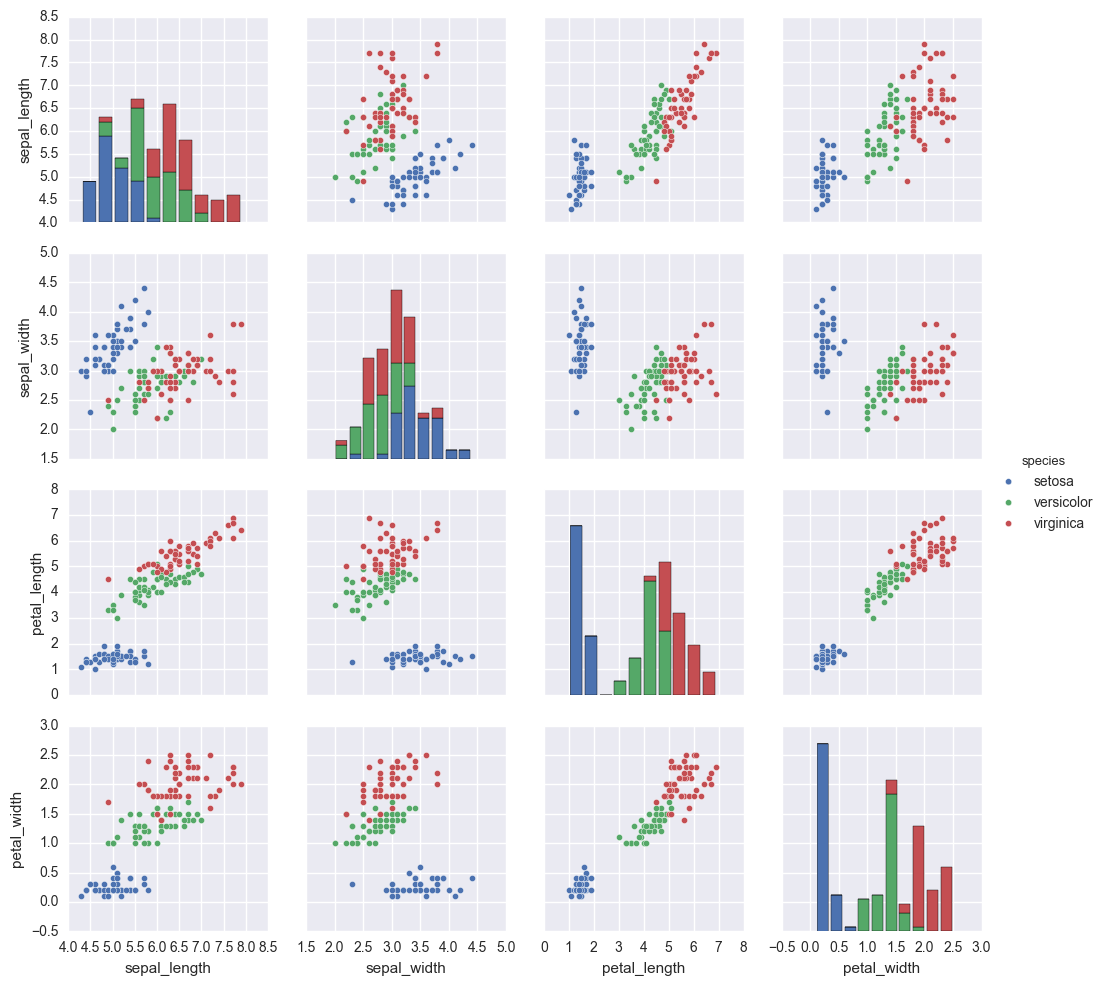

In [38]:
sns.set()
irises = sns.load_dataset("iris")
sns.pairplot(irises, hue="species")

One of the main challenges of clustering, however, is that the scale of each dimension matters: if you were to try to cluster, for example, [1] how many metres per year a glacier moved with [2] the number of cubic metres by which it grew, then you would only be clustering on variable [2]. 

That's because glaciers contain millions of cubic metres of ice and will grow or shrink by thousands of cubic metres each year. In contrast, most glaciers move at most a few metres per year. So the sheer scale difference between these two dimensions means that the values of variable 1 dominate the clustering algorithm because they provide a much better 'spread' in the data than variable 2.

To address this we need to standardise the data in some way so that the scales are relatively consistent. There's no _one_ way to standardise the data, it depends on the characteristics of the data _as well as_ what we're looking for in terms of clustering.

Does this all sound a little bit familiar from last year? Let's start by just looking at a couple of variables in a simple scatter plot...

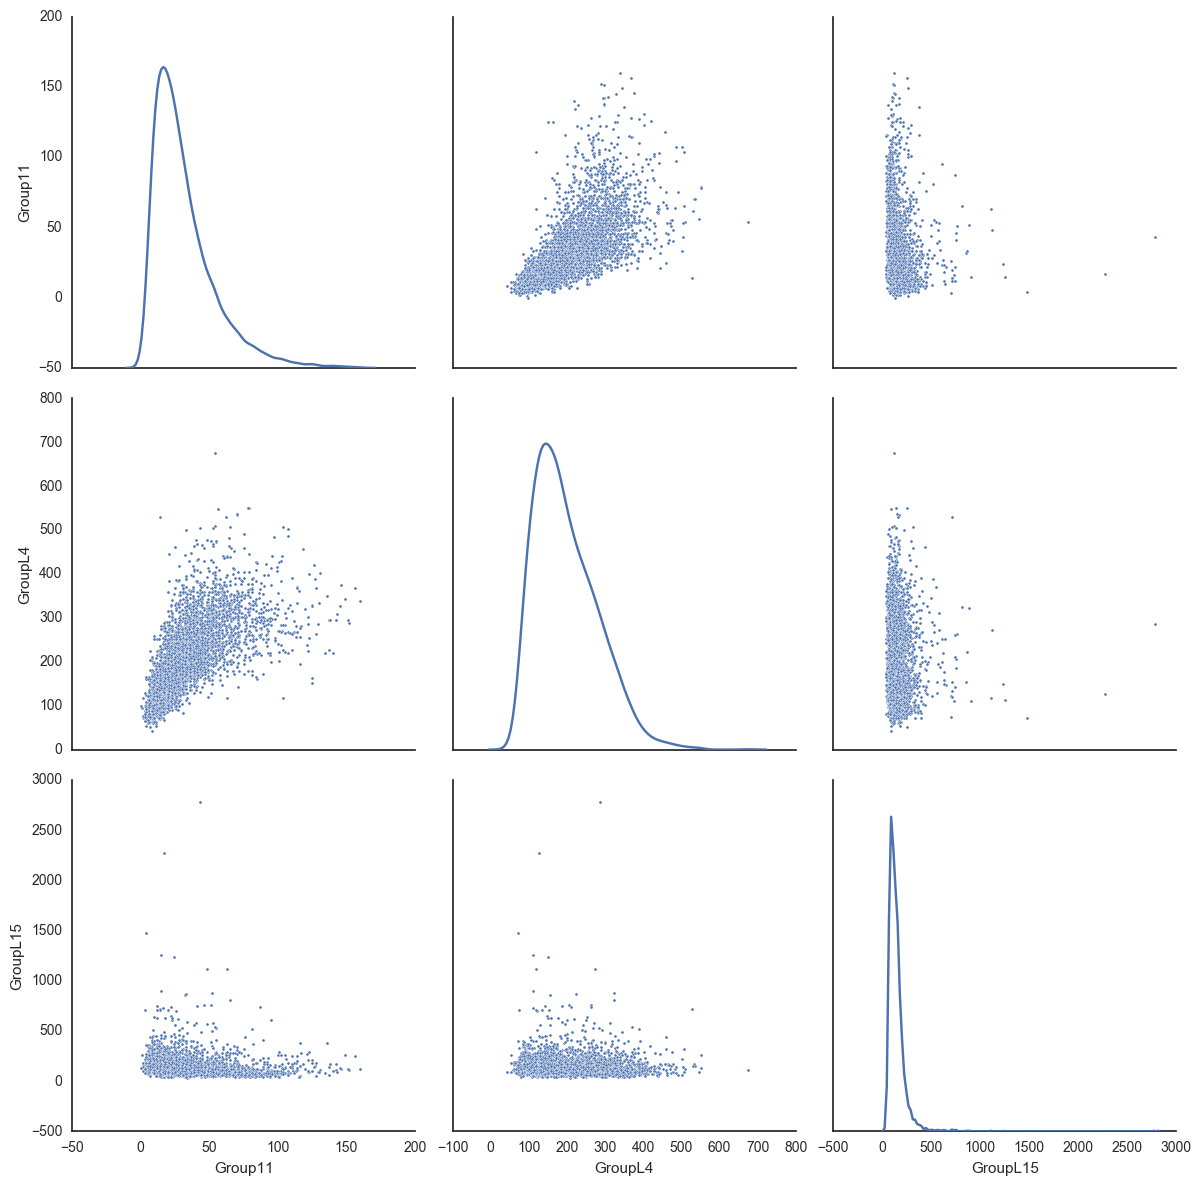

In [12]:
# The data as it is now...
sns.set(style="white")
sns.pairplot(df, 
             vars=['Group11','GroupL4','GroupL15'], 
             markers=".", size=4, diag_kind='kde')

So there are clearly some differences, but I'd be hard-pressed to give you sensible clusters just by looking at this data. Let's try normalising the data to see how it looks after:

In [15]:
# Here's how we can rescale in a robust way
import sklearn
print("SciKit-Learn verion is: " + sklearn.__version__)
from sklearn import preprocessing
help(preprocessing.robust_scale)

SciKit-Learn verion is: 0.18.1
Help on function robust_scale in module sklearn.preprocessing.data:

robust_scale(X, axis=0, with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)
    Standardize a dataset along any axis
    
    Center to the median and component wise scale
    according to the interquartile range.
    
    Read more in the :ref:`User Guide <preprocessing_scaler>`.
    
    Parameters
    ----------
    X : array-like
        The data to center and scale.
    
    axis : int (0 by default)
        axis used to compute the medians and IQR along. If 0,
        independently scale each feature, otherwise (if 1) scale
        each sample.
    
    with_centering : boolean, True by default
        If True, center the data before scaling.
    
    with_scaling : boolean, True by default
        If True, scale the data to unit variance (or equivalently,
        unit standard deviation).
    
    quantile_range : tuple (q_min, q_max), 0.0 < q_min < q_m

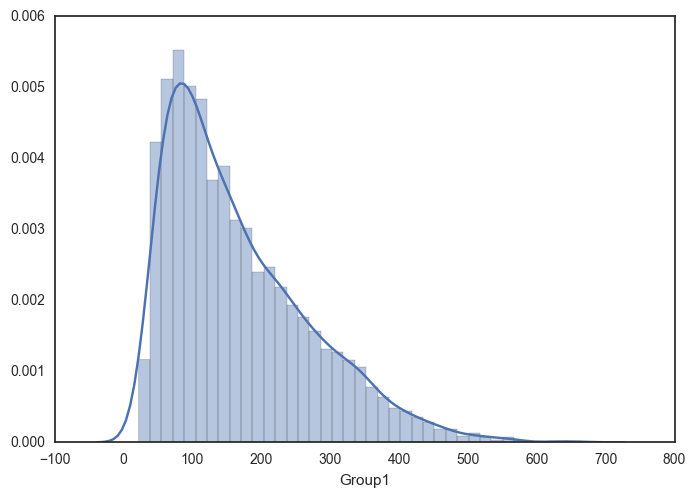

In [16]:
# Before rescaling
sns.distplot(df.Group1)

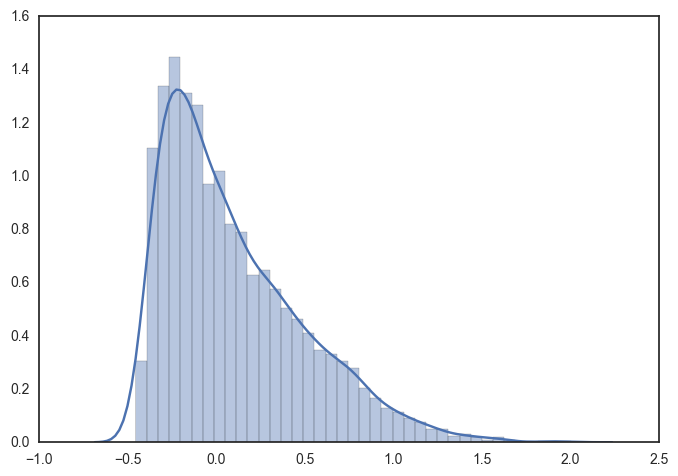

In [17]:
# After rescaling -- notice the difference?
sns.distplot(
    preprocessing.robust_scale(df.Group1.values.reshape(-1, 1), 
                               quantile_range=(10.0, 90.0)))

OK, so we've got rescaling working, but before we blindly apply this to every column in the data set let's think about what we're really up to. If we proceed with the clustering on this basis then we are clustering on _raw_ population alone. So we'll tend to find small areas being grouped together with other small areas. That's not really what we're looking for: we want areas with similar overall _profiles_ of users to come out in the same cluster.

We _could_ standardise and then rescale everything on the basis of percentage, but I prefer the LQ because it gives us a better range to work with and areas that have a relatively higher concentration of two groups will come out looking similar even if they are of very different sizes!

In [18]:
# Make numeric display a bit easier for LQs
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# Convert all of the NS-SeC Groups to LQs
for group in df.columns:
    if group.startswith('Group'):
        df[group+'LQ'] = pd.Series( (df[group]/df['Total']) / (float(df[group].sum()) / df.Total.sum()))

df.sample(3).head()

CDU    GeoCode                   GeoLabel  Total  Group1  Group11  \
675   19938  E01000690               Bromley 002B   1014     163       40   
1569  20832  E01001593             Greenwich 014C   1254     232       41   
92    19355  E01000096  Barking and Dagenham 022D   1188      33        6   

      Group12  Group2  Group3  Group4     ...      GroupNCLQ  GroupL15LQ  \
675       123     290     180     114     ...          0.526       0.526   
1569      191     442     155     102     ...          0.509       0.509   
92         27     124     118      80     ...          1.346       1.346   

      GroupL17LQ  GroupL4LQ  GroupL5LQ  GroupL6LQ  GroupL8LQ  GroupL9LQ  \
675          nan      1.118      1.388      1.755      1.351      1.148   
1569         nan      1.605      1.169      1.809      1.019      0.818   
92           nan      0.499      0.296      0.487      0.922      0.653   

      GroupL10LQ  GroupL11LQ  
675        0.839       1.118  
1569       0.887       0.657  
92         1.074       1.561  

[3 rows x 44 columns]

In [20]:
dflq = df.copy(deep=True)

# And now rescale (could do in one line, but hard to read)
for group in dflq.columns:
    if group.startswith('Group') and group.endswith('LQ'):
        print("Processing column: " + group)
        #lq = preprocessing.robust_scale(
        dflq[group] = preprocessing.robust_scale(
            dflq[group].values.reshape(-1, 1),
            quantile_range=(10.0, 90.0))
        #print(lq)

dflq.sample(3).head()

Processing column: Group1LQ
Processing column: Group11LQ
Processing column: Group12LQ
Processing column: Group2LQ
Processing column: Group3LQ
Processing column: Group4LQ
Processing column: Group5LQ
Processing column: Group6LQ
Processing column: Group7LQ
Processing column: Group8LQ
Processing column: GroupNCLQ
Processing column: GroupL15LQ
Processing column: GroupL17LQ


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Ooops, well that didn't work very well. Let's find out what is going on (big picture) by listing all of the rows that contains NULL values (which are a problem for rescaling):

In [120]:
df.isnull().any()

CDU           False
GeoCode       False
GeoLabel      False
Total         False
Group1        False
Group11       False
Group12       False
Group2        False
Group3        False
Group4        False
Group5        False
Group6        False
Group7        False
Group8        False
GroupNC       False
GroupL15      False
GroupL17      False
GroupL4       False
GroupL5       False
GroupL6       False
GroupL8       False
GroupL9       False
GroupL10      False
GroupL11      False
Group1LQ      False
Group11LQ     False
Group12LQ     False
Group2LQ      False
Group3LQ      False
Group4LQ      False
Group5LQ      False
Group6LQ      False
Group7LQ      False
Group8LQ      False
GroupNCLQ     False
GroupL15LQ    False
GroupL17LQ     True
GroupL4LQ     False
GroupL5LQ     False
GroupL6LQ     False
GroupL8LQ     False
GroupL9LQ     False
GroupL10LQ    False
GroupL11LQ    False
dtype: bool

OK, so it's only `GroupL17LQ` that's the issue here and not some systematic problem. At this point it is kind of up to us what we want to do: we could investigate further (digging into group L17 and possibly cleaning it up further... including through a simple transformation such as adding `1` to every value so that there are no zero values in the data), but since there is only this one variable and it's not integral to our analysis I'm in favour for dropping it. 

We could also explore whether `<data series>.fillna` could help us out, but I still lean towards just dropping the column because it's unlikely to be very useful to us.

In [21]:
dflq = df.copy(deep=True)

# If we find this column, this deletes it
if np.where(dflq.columns.values=='GroupL17LQ')[0]:
    del dflq['GroupL17LQ']

# And let's get rid of the non-LQ columns as well
# just to tidy up a little bit
drop = [ i for i, group in enumerate(dflq.columns) if group.startswith('Group') and not group.endswith('LQ') ]
dflq = dflq.drop(dflq.columns[drop], axis=1)

dflq.sample(3).head()

CDU    GeoCode                     GeoLabel  Total  Group1LQ  \
3789  23052  E01003875    Richmond upon Thames 006C   1123     2.158   
4705  51226  E01032789  Hammersmith and Fulham 023E    928     1.673   
1891  21154  E01001939  Hammersmith and Fulham 023C   1838     1.158   

      Group11LQ  Group12LQ  Group2LQ  Group3LQ  Group4LQ     ...      \
3789      2.482      2.081     1.494     0.896     0.814     ...       
4705      1.674      1.672     1.444     0.820     0.836     ...       
1891      1.647      1.043     0.868     0.727     0.758     ...       

      Group8LQ  GroupNCLQ  GroupL15LQ  GroupL4LQ  GroupL5LQ  GroupL6LQ  \
3789     0.355      0.661       0.661      1.509      1.705      0.911   
4705     0.742      1.026       1.026      1.524      1.348      1.103   
1891     0.815      2.105       2.105      0.849      0.999      0.702   

      GroupL8LQ  GroupL9LQ  GroupL10LQ  GroupL11LQ  
3789      1.016      0.753       0.350       0.229  
4705      0.640      0.896       0.529       0.278  
1891      0.944      0.701       0.783       0.617  

[3 rows x 23 columns]

In [22]:
# And now rescale (could do in one line, but hard to read)
for group in dflq.columns:
    if group.startswith('Group') and group.endswith('LQ'):
        print("Processing column: " + group)
        #lq = preprocessing.robust_scale(
        dflq[group] = preprocessing.robust_scale(
            dflq[group].values.reshape(-1, 1),
            quantile_range=(10.0, 90.0))
        #print(lq)

dflq.sample(3).head()

Processing column: Group1LQ
Processing column: Group11LQ
Processing column: Group12LQ
Processing column: Group2LQ
Processing column: Group3LQ
Processing column: Group4LQ
Processing column: Group5LQ
Processing column: Group6LQ
Processing column: Group7LQ
Processing column: Group8LQ
Processing column: GroupNCLQ
Processing column: GroupL15LQ
Processing column: GroupL4LQ
Processing column: GroupL5LQ
Processing column: GroupL6LQ
Processing column: GroupL8LQ
Processing column: GroupL9LQ
Processing column: GroupL10LQ
Processing column: GroupL11LQ


CDU    GeoCode        GeoLabel  Total  Group1LQ  Group11LQ  Group12LQ  \
3483  22746  E01003560     Newham 011B   1348    -0.410     -0.424     -0.404   
354   19617  E01000359     Bexley 009C    953    -0.064      0.112     -0.107   
4754  51850  E01033494  Islington 006G   1236     0.760      0.513      0.820   

      Group2LQ  Group3LQ  Group4LQ     ...      Group8LQ  GroupNCLQ  \
3483    -0.663    -0.285    -0.196     ...         0.792      1.482   
354      0.143     1.394    -0.165     ...        -0.495     -0.237   
4754     0.573    -0.375    -0.461     ...        -0.292     -0.221   

      GroupL15LQ  GroupL4LQ  GroupL5LQ  GroupL6LQ  GroupL8LQ  GroupL9LQ  \
3483       1.482     -0.594     -0.654     -0.038     -0.225     -0.132   
354       -0.237     -0.036      0.293      1.215     -0.202     -0.102   
4754      -0.221      0.745      0.140     -0.026     -0.435     -0.380   

      GroupL10LQ  GroupL11LQ  
3483      -0.082       0.021  
354        0.116       0.302  
4754      -0.315      -0.202  

[3 rows x 23 columns]

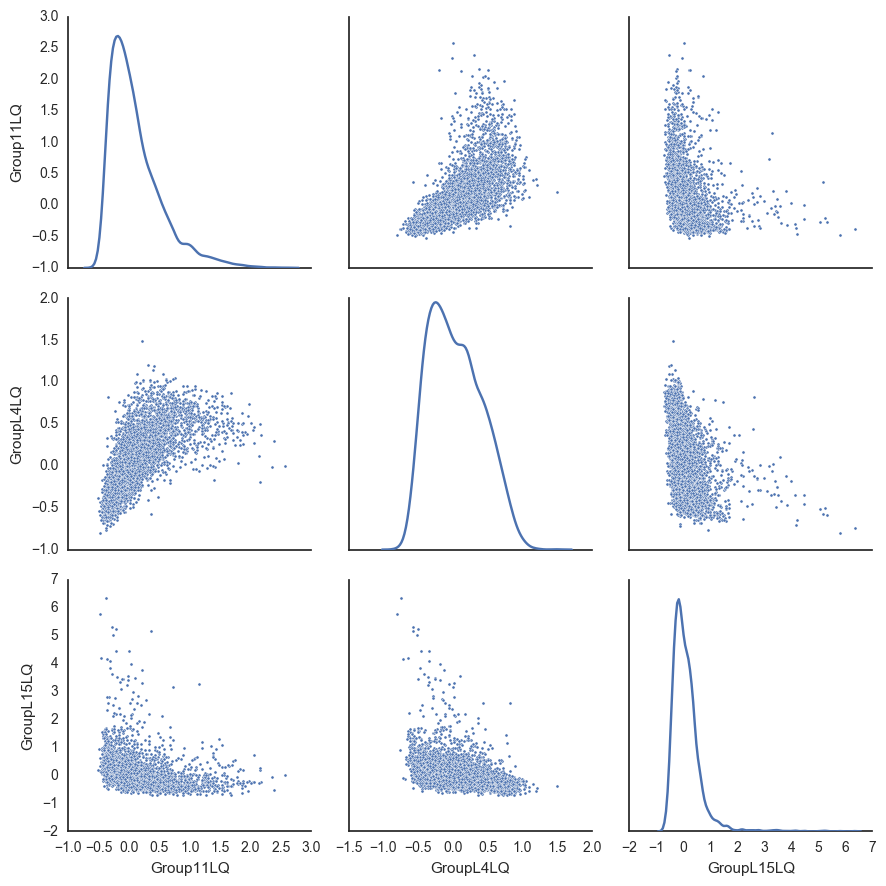

In [23]:
sns.pairplot(dflq, 
             vars=['Group11LQ','GroupL4LQ','GroupL15LQ'], 
             markers=".", size=3, diag_kind='kde')

Right, so that hasn't fundamentally changed the data, but it has rescaled it so that the majority (90%) of the data falls in the range -1 < x < 1 and yet e still have the outlier in the data. So this _should_ be a more robust approach that max/min scaling to 0-to-1 or -1-to-1 because it allows outliers to remain outliers without over-compressing the data falling within the specified quantile range. You could also do IQR standardisation using 0.25 and 0.75 as the threshold in the rescaling process, but in that case you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

## Let's Cluster!

### Organising the Data


### K-Means

In [24]:
from sklearn.cluster import KMeans
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up co

The next code block may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. It's a useful way to get a sense of what's going on, and you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! Try doing that in Excel or SPSS?

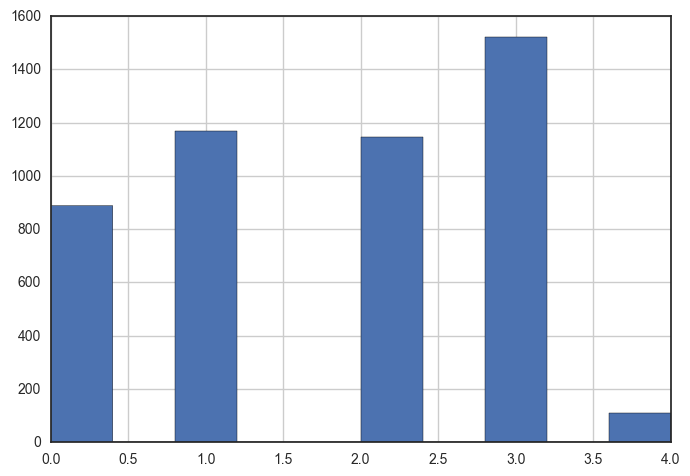

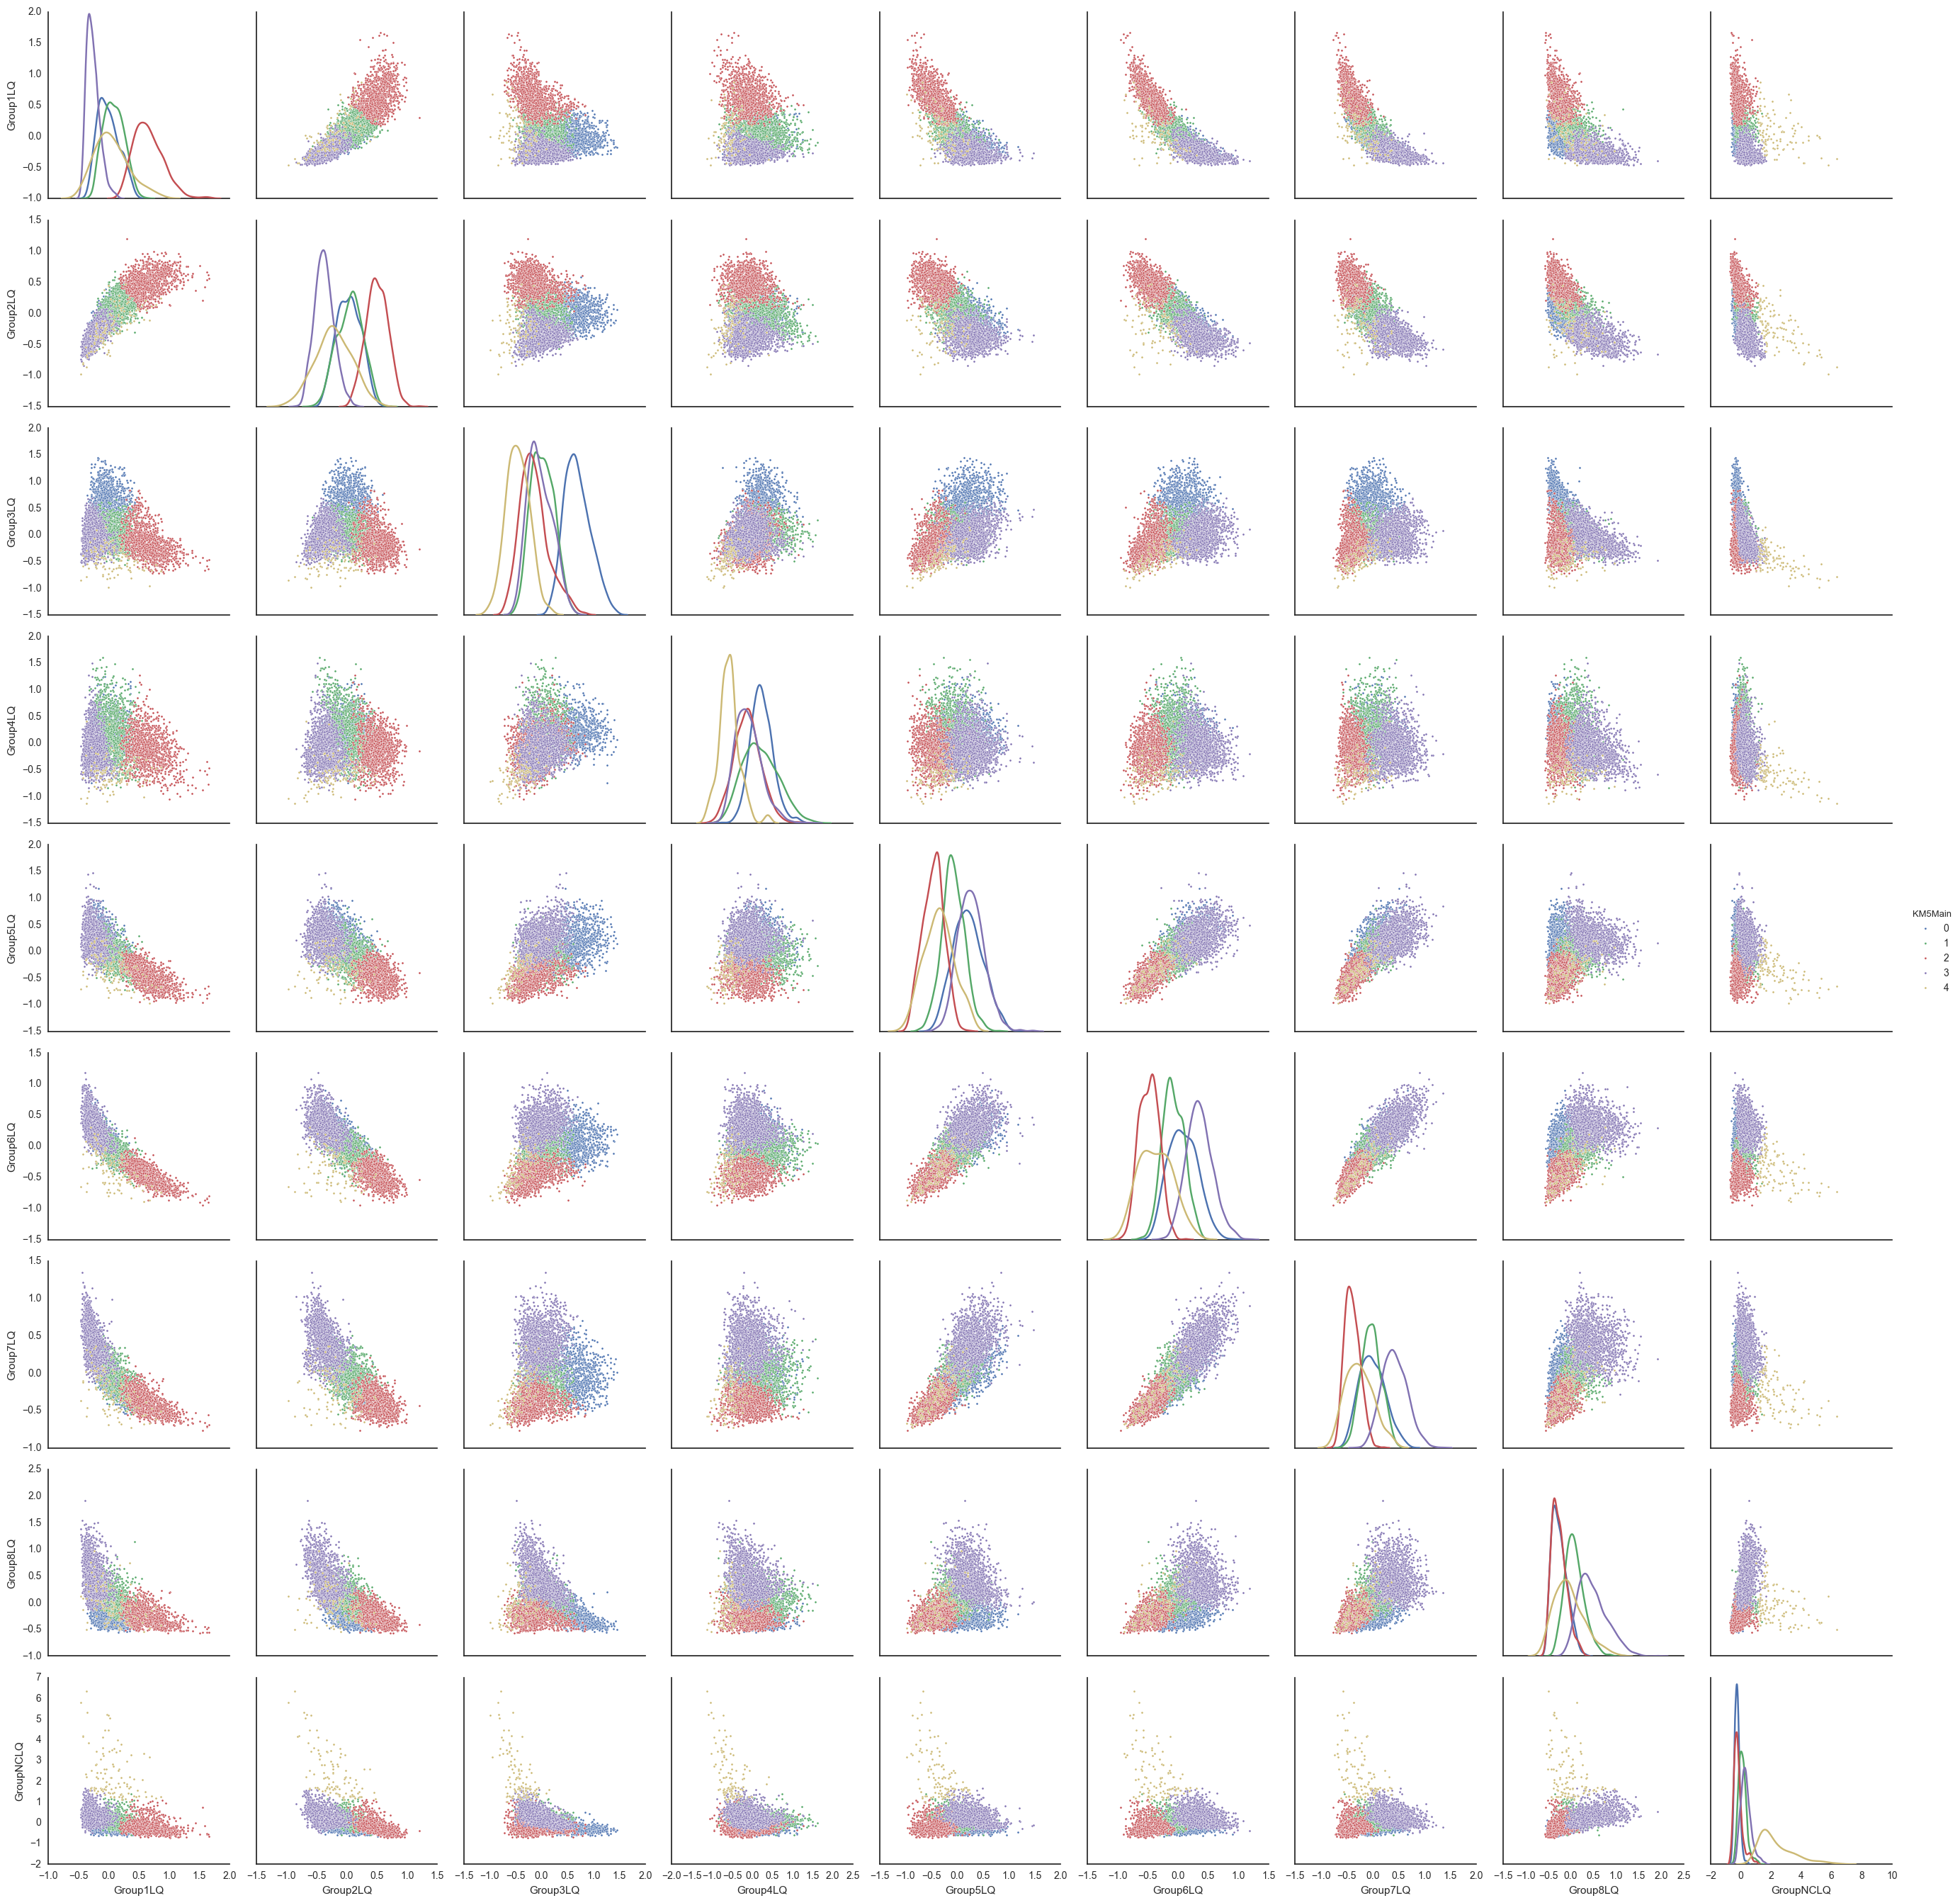

In [25]:
main_cols = ['Group1LQ','Group2LQ','Group3LQ','Group4LQ','Group5LQ','Group6LQ','Group7LQ','Group8LQ','GroupNCLQ']
kmeans = KMeans(n_clusters=5).fit(dflq[main_cols])
dflq['KM5Main'] = pd.Series(kmeans.labels_)
dflq.KM5Main.hist() # How are the clusters distributed?
# Going to be a bit hard to read
sns.pairplot(dflq,  
             vars=main_cols, 
             hue='KM5Main', markers=".", size=3, diag_kind='kde')

If we just take a subset (below) it might be a bit easier to see if this did what we wanted... In the example below you'll see that the outliers on the Group 1 and Not Classified LQ dimensions have been grouped into clusters. The other clusters have tended to cut through the bulk of the data, but if you look at the above map then you'll see that it has done a decent job of splitting the data sets into groups given that most of the data _isn't_ extreme.

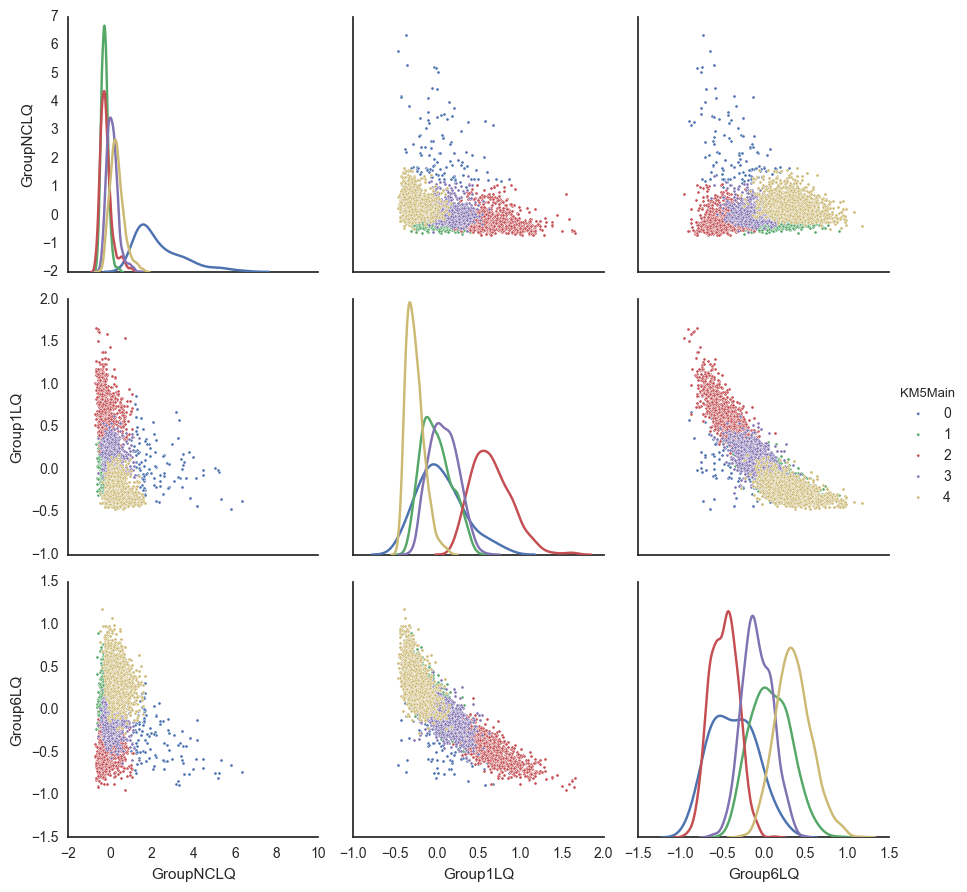

In [143]:
sns.pairplot(dflq,  
             vars=['GroupNCLQ','Group1LQ','Group6LQ'], 
             hue='KM5Main', markers="o", size=3, diag_kind='kde')

There's just _one_ little problem: what assumption did I make when I started this _k_-means cluster analysis? It's a huge one, and it's one of the reasons that _k_-means clustering _can_ be problematic when used naively...

How did I pick the number of clusters?

### The Silhouette Plot

To try to make the process of selecting the number of clusters a little less arbitrary, the silhouette plot allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. So to evaluate this in a systematic way, we want to do _multiple_ _k_-means passes at _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-7.

Cluster count: 3
('For k =', 3, 'The average silhouette_score is :', 0.27076680456179603)


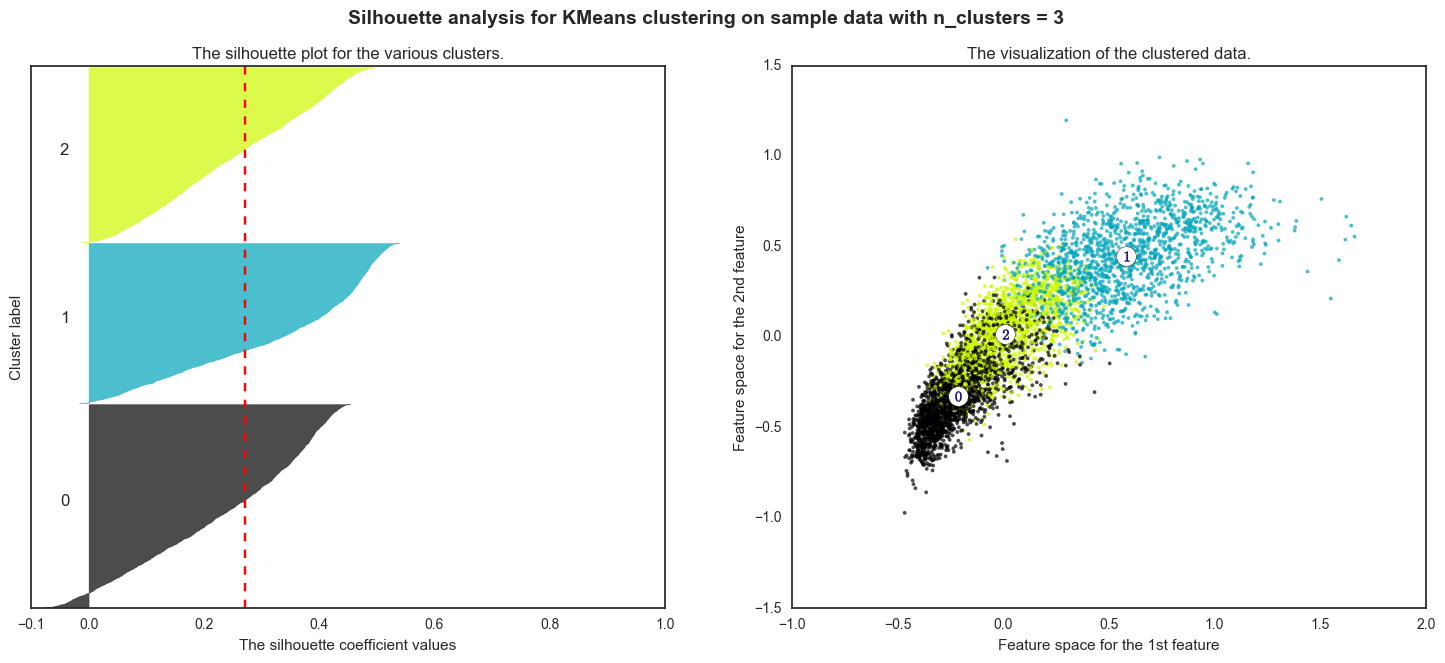

Cluster count: 4
('For k =', 4, 'The average silhouette_score is :', 0.28719529737067501)


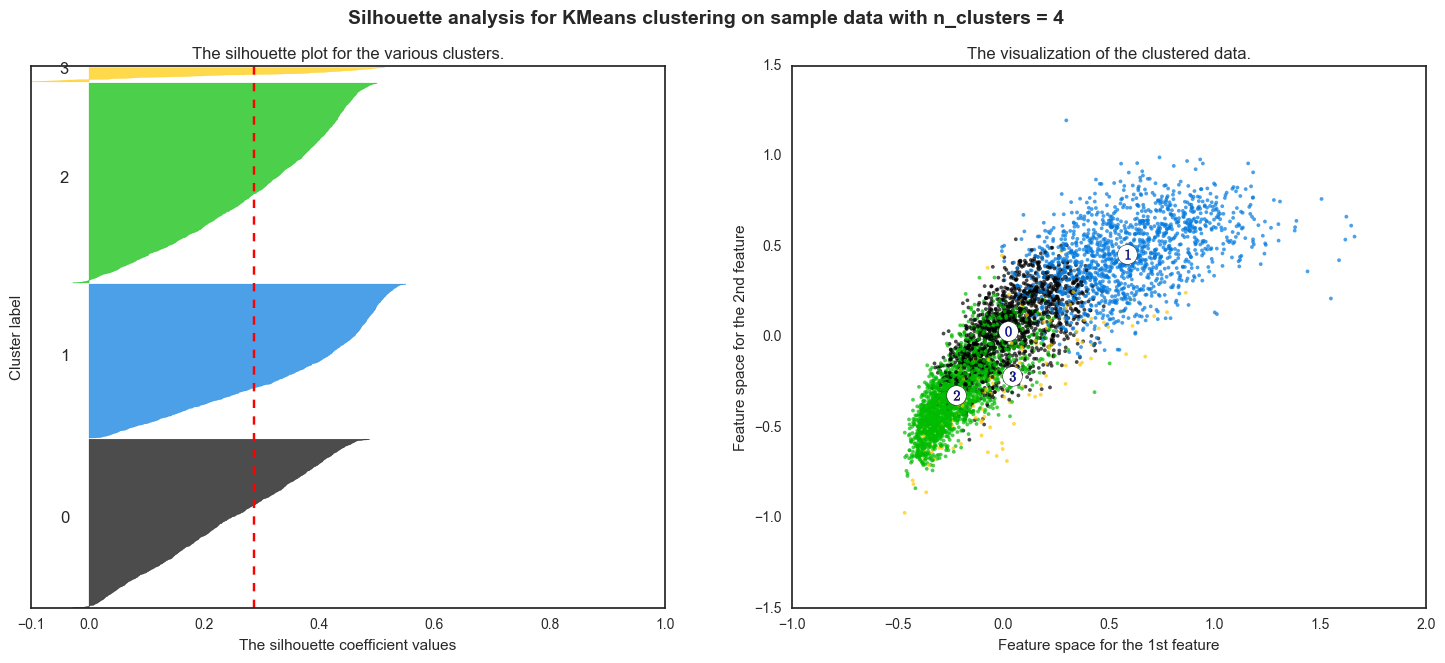

Cluster count: 5
('For k =', 5, 'The average silhouette_score is :', 0.25572371287504697)


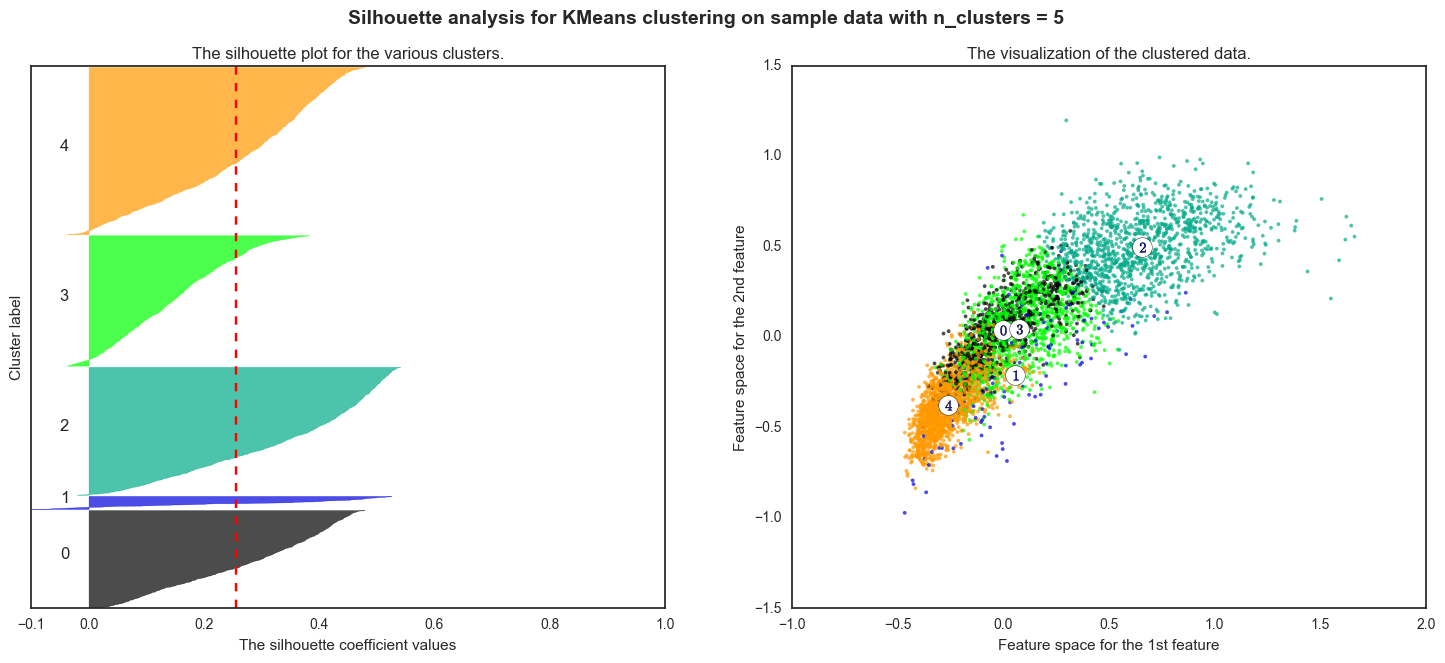

Cluster count: 6
('For k =', 6, 'The average silhouette_score is :', 0.23058600820541128)


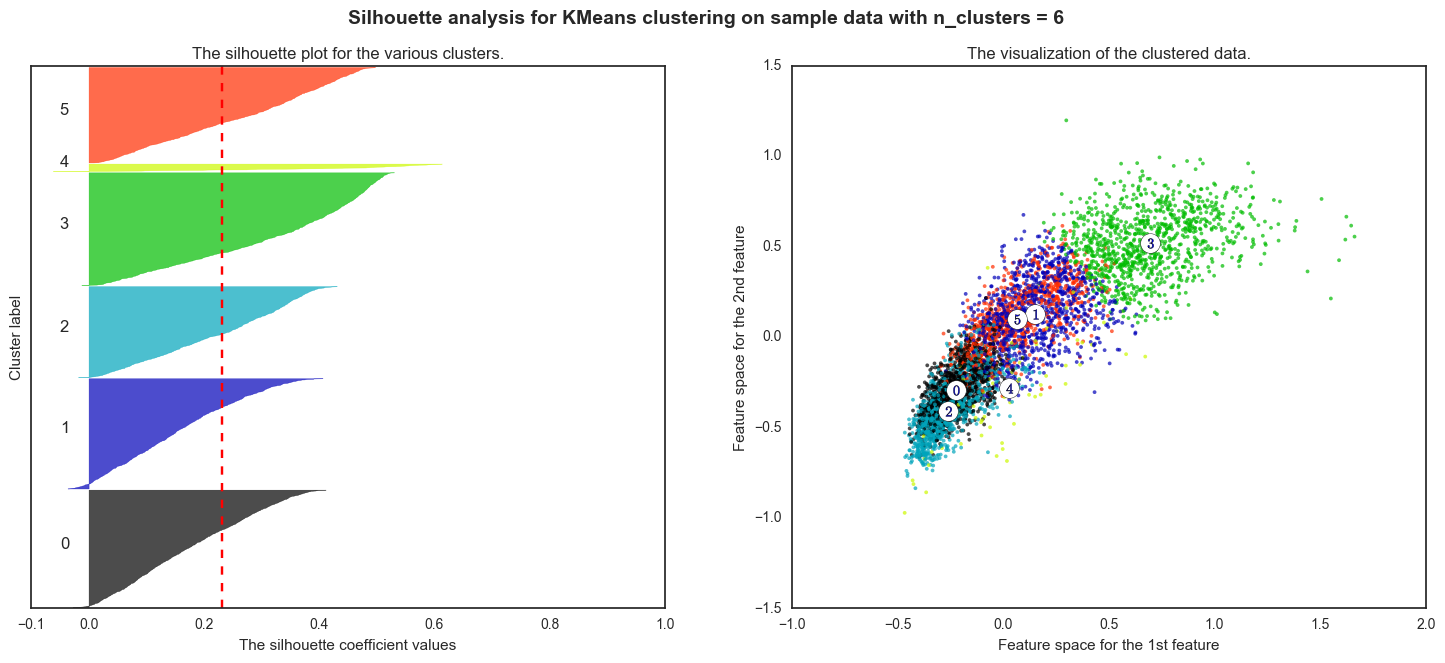

Cluster count: 7
('For k =', 7, 'The average silhouette_score is :', 0.23320639562525411)


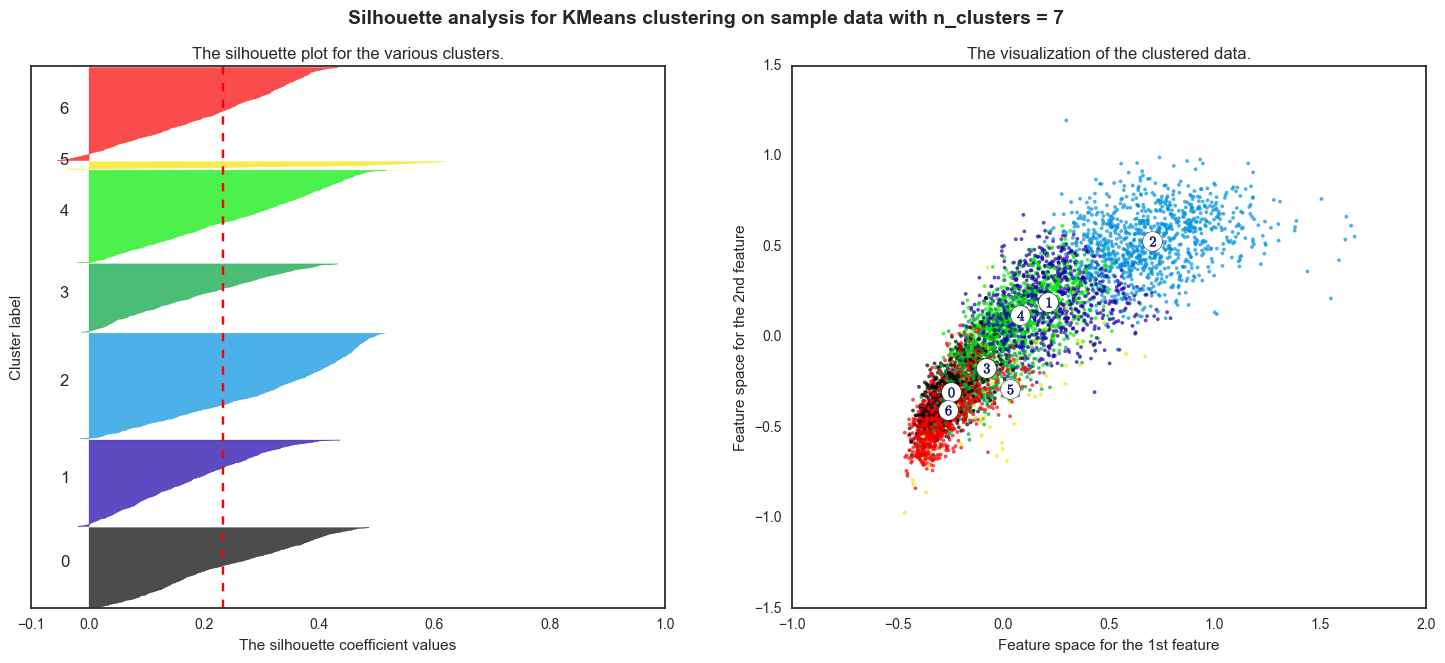

In [38]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for k in range(3,8):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(dflq[main_cols])
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(dflq[main_cols], cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(dflq[main_cols], cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, dflq.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = cm.spectral(cluster_labels.astype(float) / k)
    ax2.scatter(dflq[main_cols[0]], dflq[main_cols[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

### Interpreting the Results

The results above suggest that 4 clusters is probably 'best' -- but that's only if we don't have any kind of underlying _theory_ or other _empirical evidence_ for choosing a different value... Let's repeat the 4-cluster process and then map it.

In [41]:
kmeans = KMeans(n_clusters=4).fit(dflq[main_cols])
dflq['KMMain'] = pd.Series(kmeans.labels_)

sdf = gdf.merge(dflq, left_on='lsoa11cd', right_on='GeoCode', how='inner')

sdf.sample(5)[['GeoCode','Group1LQ','GroupNCLQ','KMMain']]

GeoCode  Group1LQ  GroupNCLQ  KMMain
1973  E01002022     0.465     -0.468       3
1257  E01001277     0.103      0.054       0
2709  E01002774     0.096     -0.036       3
340   E01000345    -0.028     -0.145       0
2154  E01002204    -0.001      0.174       0

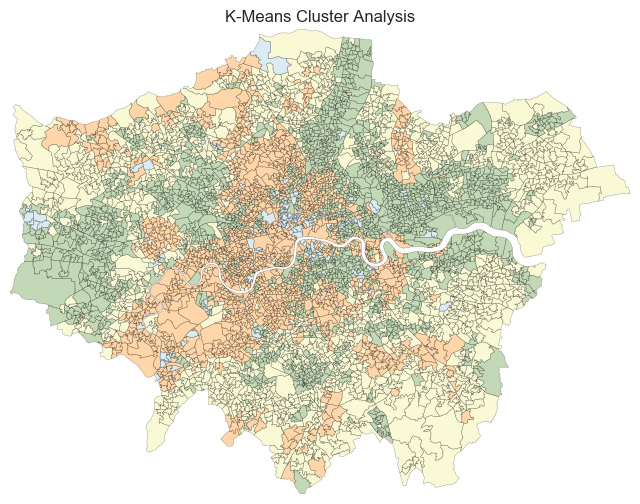

In [42]:
from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('KMMain'))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='K-Means Cluster Analysis', figsize=(8,6))

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. You could also think of ways of plotting how these groups differ. For instance...

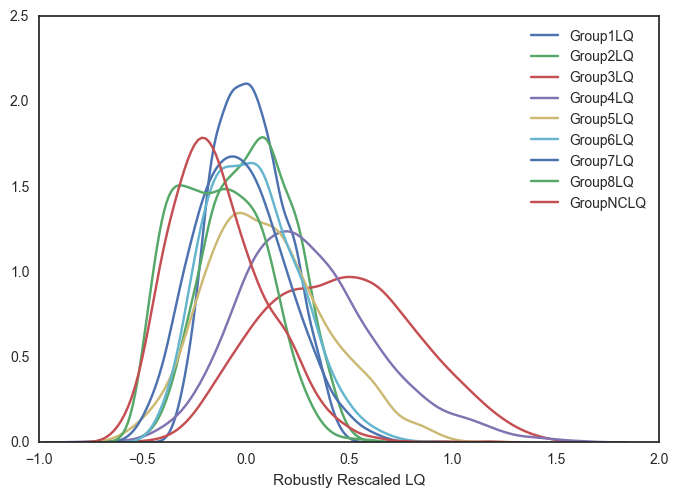

In [53]:
k1 = dflq[dflq.KMMain==3]
for c in main_cols:
    sns.distplot(k1[c], hist=False, kde=True, label=c, axlabel='Robustly Rescaled LQ')

### DBScan

Of course, as we've said above _k_-means is just one way of clustering, DBScan is another. Unlike _k_-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify _other_ parameters and these can have a huge impact on our results!

In [66]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN().fit(dflq[main_cols])

dflq['DBSCAN'] = pd.Series(dbs.labels_)

dflq.DBSCAN.value_counts()

 0    4734
-1      80
 1      13
 2       8
Name: DBSCAN, dtype: int64

In [58]:
sdf = gdf.merge(dflq, left_on='lsoa11cd', right_on='GeoCode', how='inner')

sdf.sample(5)[['GeoCode','Group1LQ','GroupNCLQ','KMMain','DBSCAN']]

GeoCode  Group1LQ  GroupNCLQ  KMMain  DBSCAN
2402  E01002454    -0.240     -0.133       0       0
2805  E01002870    -0.212      0.185       1       0
2273  E01002324    -0.180     -0.327       0       0
2540  E01002598    -0.282     -0.007       1       0
4536  E01004650     0.908     -0.193       3       0

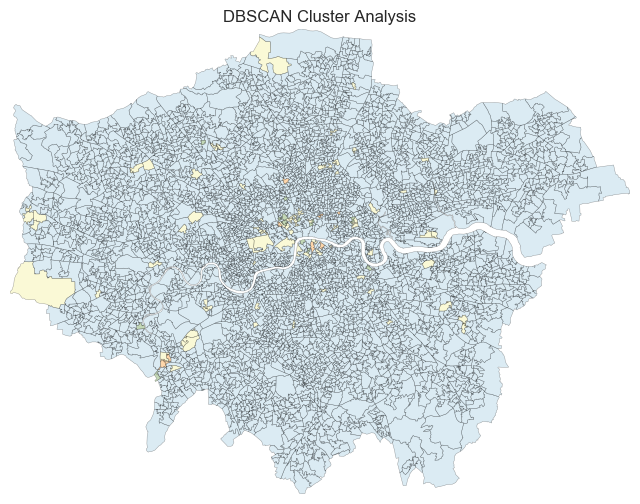

In [67]:
from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('DBSCAN'))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='DBSCAN Cluster Analysis', figsize=(8,6))

So, rather less useful than we might have initially hoped... let's look at those parameters again.

In [68]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster.dbscan_:

class DBSCAN(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, optional
 |      The maximum distance between two samples for them to be considered
 |      as in the same neighborhood.
 |  
 |  min_samples : int, optional
 |      The number of samples (or total weight) in a neighborhood for a point
 |      to be considered as a core point. This includes the point itself.
 |  
 |  metric : string, or callable
 |      The metric to use when calculating distance between instances in a
 |      feature array. If metric is a string or callable, it must 

In [82]:
dbs = DBSCAN().fit(dflq[main_cols])

dflq['DBSCAN'] = pd.Series(dbs.labels_)

dflq.DBSCAN.value_counts()

 0    4734
-1      80
 1      13
 2       8
Name: DBSCAN, dtype: int64

### Max-P

Finally, max-p is _not_ in sklear because it's an explicitly geographical clustering algorithm. It's in [PySAL](http://pysal.readthedocs.io/en/latest/users/tutorials/region.html).

In [90]:
w = ps.queen_from_shapefile(shp_link, idVariable='GeoCode')
print("%.4f"%w.pct_nonzero)

0.1227


In [91]:
help(ps.Maxp)

Help on class Maxp in module pysal.region.maxp:

class Maxp
 |  Try to find the maximum number of regions for a set of areas such that
 |  each region combines contiguous areas that satisfy a given threshold
 |  constraint.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |  w               : W
 |                    spatial weights object
 |  
 |  z               : array
 |                    n*m array of observations on m attributes across n
 |                    areas. This is used to calculate intra-regional
 |                    homogeneity
 |  floor           : int
 |                    a minimum bound for a variable that has to be
 |                    obtained in each region
 |  floor_variable  : array
 |                    n*1 vector of observations on variable for the floor
 |  initial         : int
 |                    number of initial solutions to generate
 |  verbose         : binary
 |                    if true debugging information is printed
 |  seeds           : list
 |

In [92]:
random.seed(100)
np.random.seed(100)
r = ps.Maxp(w, dflq[main_cols].values, floor=50, floor_variable=np.ones((w.n,1),float), initial=99)

KeyboardInterrupt: 

In [ ]:
r.regions

In [ ]:
names = dflq['GeoLabel']
for region in r.regions:
    ids = map(int,region)
    print names[ids]